# Analysis of Rolling Sales Data - Queens

# Steps

I am going to do the following:

    1. Import necessary modules
    2. Load the prepped data per borough 
    3. Analyze the data for trends and seasonality
    4. Dickey-Fuller Tests and preparing data for ARMA modeling by inducing stationarity
    5. ARMA model of the data
    6. Error analysis of the ARMA model
    7. Comparison with latest data
    8. Onservations/Conclusions

## 1. Imports

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import datetime
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

## 2. Loading the prepared data

##### Observations: 
 - Once I loaded the data and sorted it, the SALE DATE values range from 4/1/2020 until 3/31/2021.
 - This data was the most recent data when I started working on the project. 
 - NYC OpenData website updates this data regularly with newer months about every 2-3 months

In [12]:
df = pd.read_csv('rollingsales_queens.xls_prepped_bare.csv')
df.reset_index(drop=True, inplace=True)
df.sort_values('SALE DATE')

,TAX CLASS AT PRESENT,ZIP CODE,SALE PRICE,SALE DATE
11776,1,11434,434500,2020-04-01
5303,2,11375,1150000,2020-04-01
10406,4,11418,2500000,2020-04-01
11814,1,11434,358000,2020-04-01
12658,1,11357,720000,2020-04-01
...,...,...,...,...
13114,2,11377,370000,2021-03-31
10094,1,11418,773800,2021-03-31
5566,2,11004,167600,2021-03-31
5156,2,11375,425000,2021-03-31


## 3. Analyzing the data for trends/seasonality

I do the following steps here to help the data work with the modules:

    1. Convert 'SALE DATE' column to datetime format
    2. Create new dataframe with 'SALE DATE' as the index and 'SALE PRICE' as the column
    3. Since we have multiple sales per day, I will aggregate the data into daily data by taking the daily average of sales
    4. Check the data for any nulls/NaNs
    5. Use statsmodels to observe the data for trends and seasonality
    
##### Observations:
    - NaN values came into the data after the data got aggregated. 
    - Upon further inspection, this was due to the 70 days of no sales in the origional data. 
    - Thus, after aggregation, there were 70 days with no data, which I dropped

In [34]:
# Convert 'SALE DATE' column to datetime format
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])

In [35]:
# Create new dataframe with 'SALE DATE' as the index and 'SALE PRICE' as the column
df_price_date = pd.DataFrame(df, columns=['SALE DATE', 'SALE PRICE'])
df_price_date = df_price_date.set_index('SALE DATE')
df_price_date.head()

,SALE PRICE
SALE DATE,
2020-07-16,4121000
2020-08-28,584569
2021-01-11,800000
2020-12-16,300000
2020-06-23,360000


In [36]:
#Group the sales data by daily average
df_price_date = df_price_date.resample('D').mean()

In [37]:
# We see here number of rows went down from 13171 to 295. Why wasn't it 365 rows to represent all days of the year?
df_price_date.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-04-01 to 2021-03-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SALE PRICE  295 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [39]:
#Here we see that since we resampled by day, there are NaN values for the days that there were no sales due to no sale date, pandas autofilled it with NaN
df_price_date['SALE PRICE'].isna().sum()

70

In [42]:
df_price_date.dropna(inplace=True)
df_price_date

,SALE PRICE
SALE DATE,
2020-04-01,961150.000000
2020-04-02,753357.142857
2020-04-03,681724.206897
2020-04-06,725208.000000
2020-04-07,630053.736842
...,...
2021-03-25,609609.756098
2021-03-26,652589.285714
2021-03-29,694114.470588


In [84]:
# df_price_date.rolling(window=2).mean().head()
df_price_date['roll_avg'] = df_price_date.rolling(window=7).mean()
df_price_date

,SALE PRICE,roll_avg
SALE DATE,,
2020-04-01,961150.000000,NaN
2020-04-02,753357.142857,NaN
2020-04-03,681724.206897,NaN
2020-04-06,725208.000000,NaN
2020-04-07,630053.736842,NaN
...,...,...
2021-03-25,609609.756098,560096.239773
2021-03-26,652589.285714,548271.167382
2021-03-29,694114.470588,559603.341147


I plotted the data here against its 7 day rolling average to see if I can discern any pattern

Text(0, 0.5, 'Average Price')

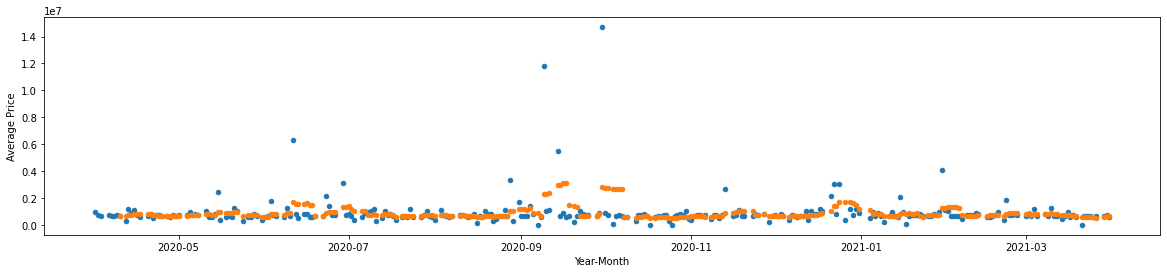

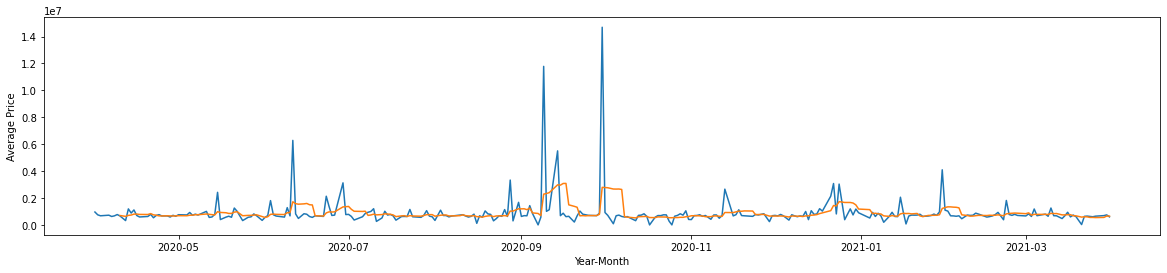

In [88]:
plt.figure(figsize=(20, 4))
plt.xlabel("Year-Month")
plt.ylabel("Average Price")
#s=20 to keep dots small in size
plt.scatter(df_price_date.index[:295], df_price_date['SALE PRICE'][:295], s=20)
plt.scatter(df_price_date.index[7:], df_price_date['roll_avg'][7:], s=20);
plt.figure(figsize=(20, 4))
plt.plot(df_price_date.index[:295], df_price_date['SALE PRICE'][:295])
plt.plot(df_price_date.index[7:], df_price_date['roll_avg'][7:]);
plt.xlabel("Year-Month")
plt.ylabel("Average Price")

In [89]:
# Statsmodels
decomposition = seasonal_decompose(df_price_date['SALE PRICE'], model='multiplicative', period=30)
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [90]:
register_matplotlib_converters()

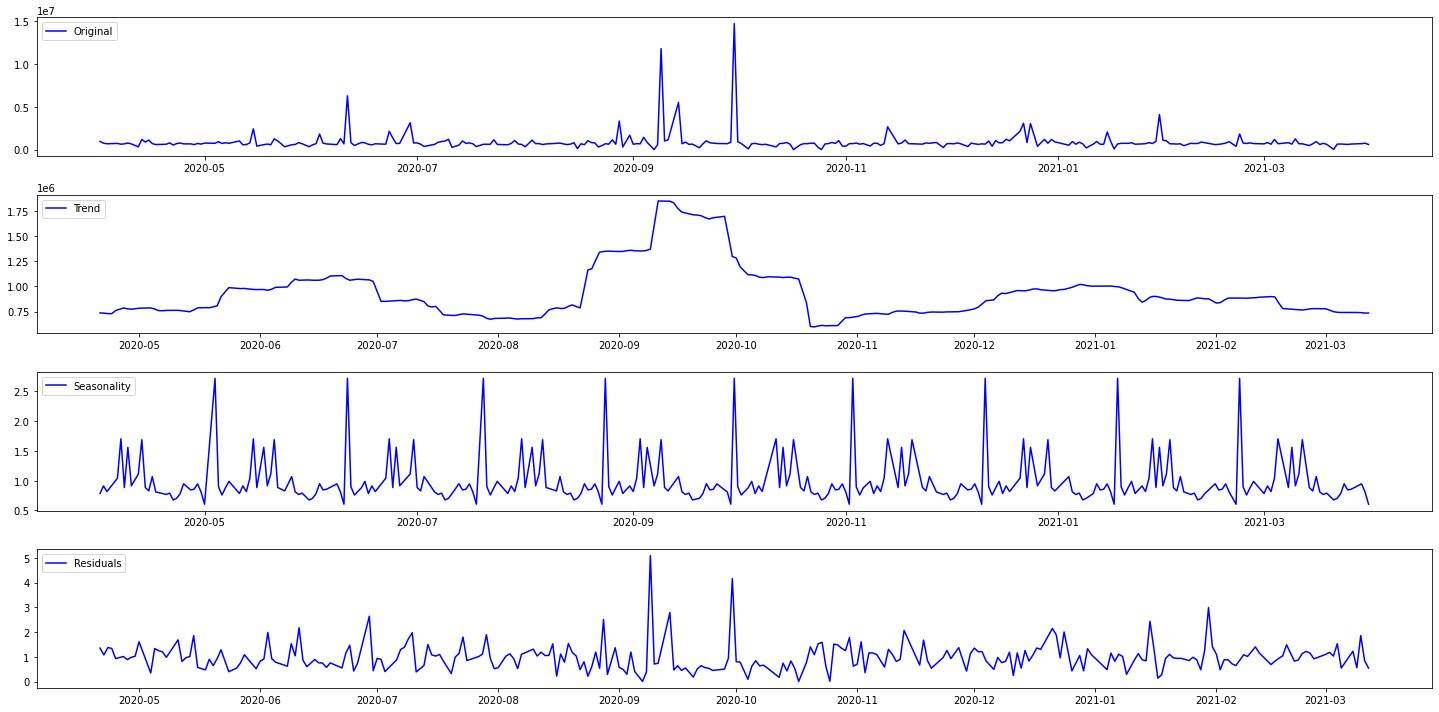

In [91]:
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

##### Observations: 
 - A large amount of sales happened between August 2020 and November 2020. 
 - There was some seasonality that happened once a month and in the middle of the month

## 4. Dickey-Fuller Tests and preparing data for ARMA modeling by inducing stationarity

I had to do the following to induce stationarity:

In [49]:
# Initial test
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-2.6447743906943435, 0.08409181983183306, 15, 279, {'1%': -3.4540076534999957, '5%': -2.8719557347997178, '10%': -2.5723200648758366}, 8581.215834206878)

Test Statistic                  -2.644774
p-value                          0.084092
#Lags Used                      15.000000
Number of Observations Used    279.000000
Critical Value (1%)             -3.454008
Critical Value (5%)             -2.871956
Critical Value (10%)            -2.572320
dtype: float64


##### Observation: 
Initial test shows Test Statistic of -2.6448, this is greater than the critical values.

Dickey Fuller Test
- We see that test statistic value is -2.6448
- We see that the critical values are LESS than the test statistic. (-3.45, -2.87, -2.57)
- We accept the null that the time series is not stationary!

P-Value analysis
If p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

Our current p-value is 0.733585
This means: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

If p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
Our goal is to make the data stationary